In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(check_output(['ls', '../input/nyc-taxi-trip-duration']).decode('utf-8'))

sample_submission.zip
test.zip
train.zip



In [2]:
base_dir = '../input/nyc-taxi-trip-duration'
train_dir = os.path.join(base_dir, 'train.zip')
test_dir = os.path.join(base_dir, 'test.zip')

import zipfile

with zipfile.ZipFile(train_dir, 'r') as z:
    z.extractall()

In [3]:
df = pd.read_csv("./train.csv")

In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])]

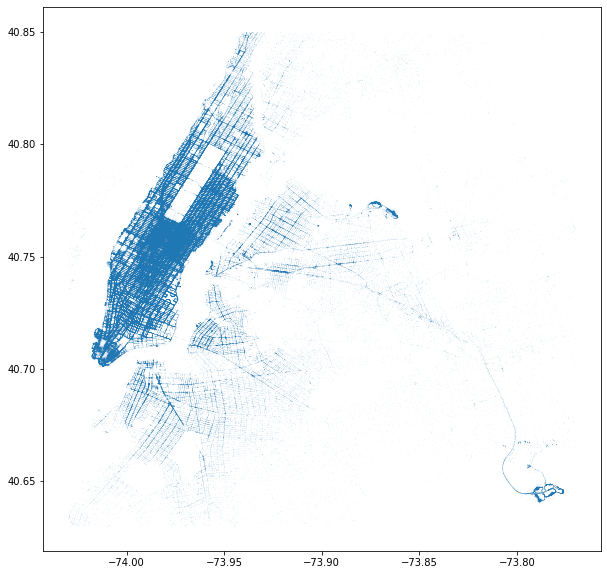

In [6]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10, 10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 0.05)
plt.show()

In [7]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

In [8]:
loc_df.head()

,longitude,latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209


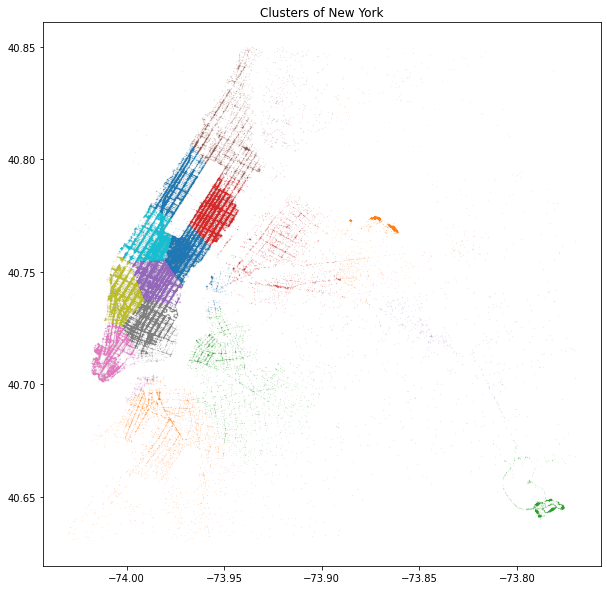

In [9]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

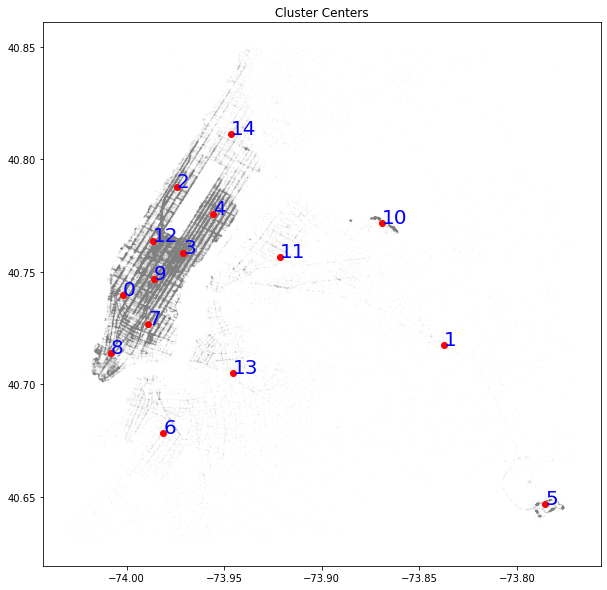

In [10]:
fig, ax = plt.subplots(figsize = (10, 10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label],
          '.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1], 'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1]), color = 'b', fontsize = 20)
    ax.set_title('Cluster Centers')
plt.show()

In [11]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour)

In [12]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,12,3,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,9,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,12,8,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,8,8,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2,2,13


In [13]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [14]:
loc_df = loc_df.sample(5000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



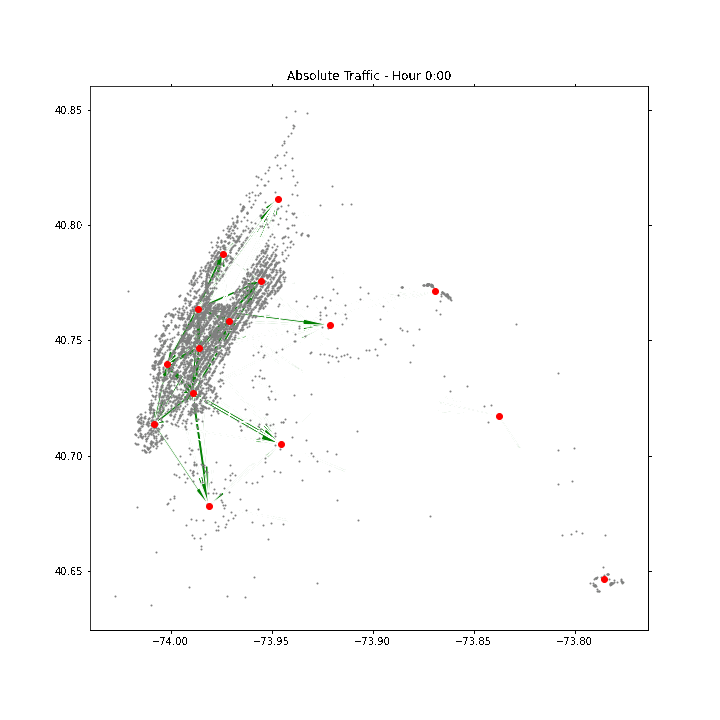

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')
    plt.figure(figsize=(10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label],
               '.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    
    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides, len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
    
ani = animation.FuncAnimation(fig, animate, sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



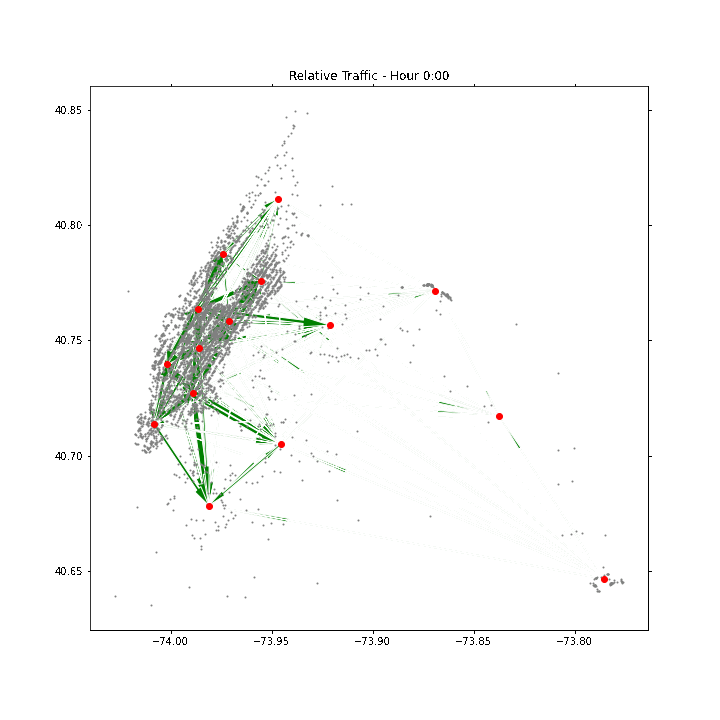

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')

    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [17]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [18]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [19]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

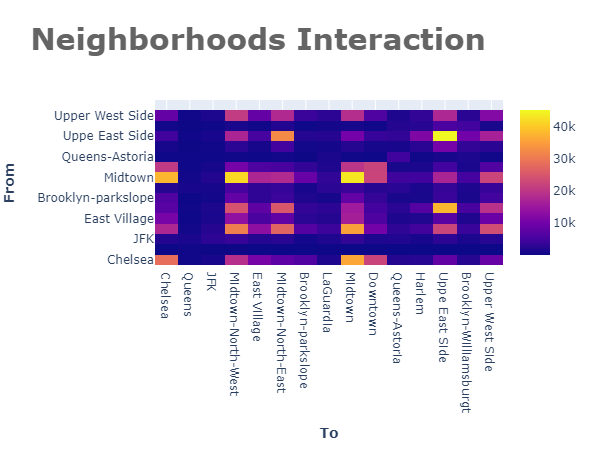

In [20]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides_df),x = rides_df.columns[:-1],y = rides_df.columns)
layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(title = ' <b> From </b>'),
        xaxis = dict(title = '<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [21]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)
rides_df.head()

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side
name,,,,,,,,,,,,,,,
Chelsea,28526,228,950,18989,10622,7657,6141,1497,35963,22084,2119,2209,7998,2317,8742
Queens,27,375,93,55,37,20,5,120,33,24,43,15,43,15,41
JFK,1887,1221,2779,3578,2116,2351,743,1463,3207,1576,1749,993,2847,1244,2208
Midtown-North-West,17496,416,2183,30833,13214,27005,6747,4206,35307,10196,2940,4654,22343,3898,23537
East Village,10616,186,1168,13532,5619,8030,2622,2073,16225,5980,1625,1793,7099,1704,9138


Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

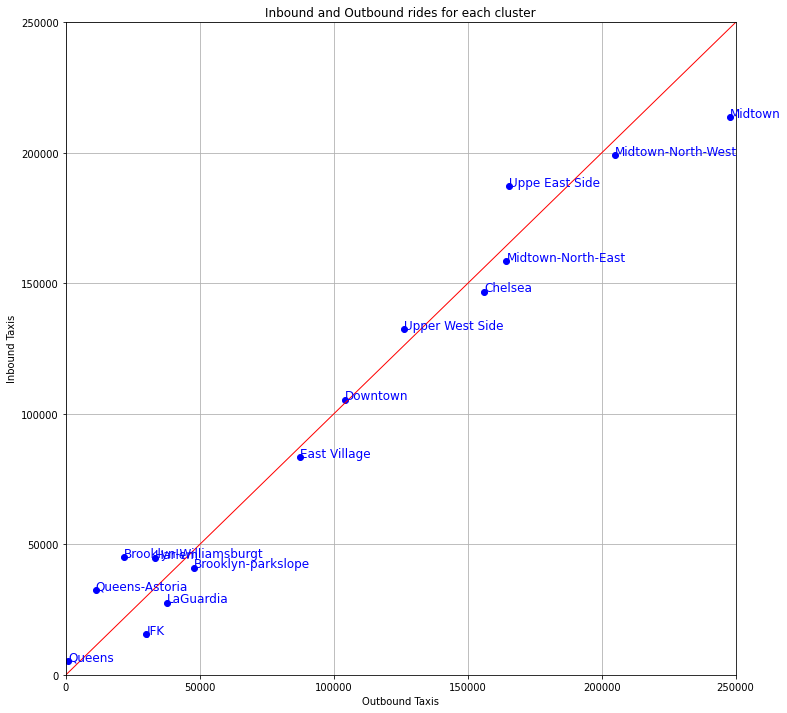

In [25]:
fig, ax = plt.subplots(figsize = (12, 12))
for i in range(len(rides_df)):
    ax.plot(rides_df.sum(axis = 1)[i], rides_df.sum(axis = 0)[i], 'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i], rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000], [0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

In [29]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x:parser.parse(x).month)

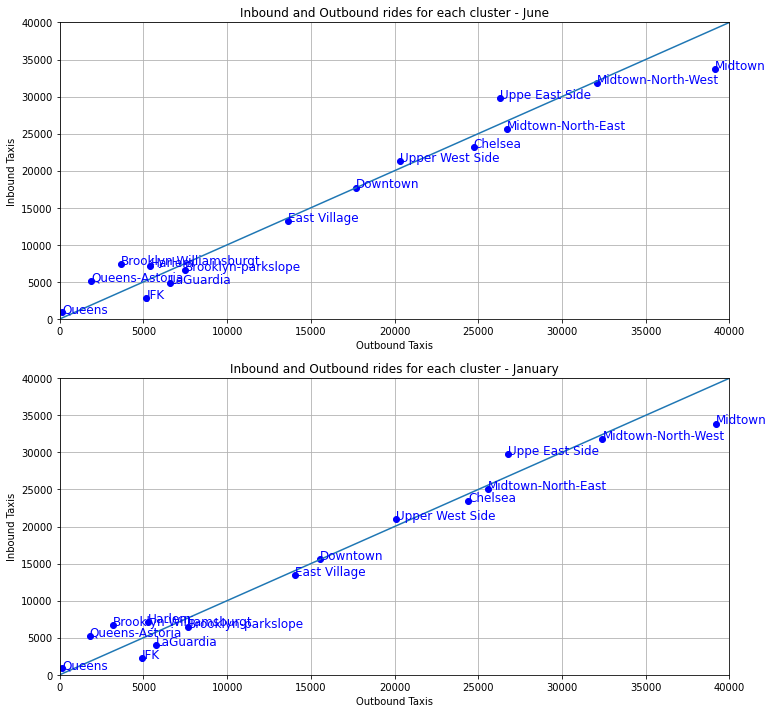

In [30]:
fig, ax = plt.subplots(2, figsize=(12,12))
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
for i in range(len(rides_df)):
    ax[0].plot(rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i], 'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]), color = 'b', fontsize=12)
    
ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000], [0,40000])

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x:len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
rise_df = rides_df.drop('name', axis = 1)

for i in range(len(rides_df)):
    ax[1].plot(rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i], 'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]), color = 'b', fontsize=12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0, 40000])
ax[1].set_ylim([0, 40000])
ax[1].plot([0, 40000], [0, 40000])